In this notebook, I describe how DRAG coefficients can be obtained.

### References

[1]: Li, Z., Liu, P., Zhao, P. *et al.* Error per single-qubit gate below 10−4 in a superconducting qubit. *npj Quantum Inf* **9**, 111 (2023). [https://doi.org/10.1038/s41534-023-00781-x](https://doi.org/10.1038/s41534-023-00781-x).

[2]: Z. Chen *et al.* Measuring and Suppressing Quantum State Leakage in a Superconducting Qubit. *Phys. Rev. Lett.* **116**, 020501 (2016) [https://doi.org/10.1103/PhysRevLett.116.020501](https://doi.org/10.1103/PhysRevLett.116.020501). 

## Dependencies

In [1]:
%config InlineBackend.figure_formats = ['svg']

In [2]:
import os
os.chdir('/Users/ngdnhtien/Codespace/PulsatingPulseShop/')

In [3]:
# Necessary dependencies

# qiskit
from qiskit import pulse
from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit, Gate
from qiskit_ibm_provider import IBMProvider

# qutritium
from utility import *
from constant import *

# numerical
import numpy as np
from scipy.optimize import curve_fit
import pickle 

# plot
from matplotlib.ticker import MultipleLocator

plt.rcParams['axes.linewidth'] = 1.25

## Derivative Removal of Adiabaticity Gates

[1]: Sheldon *et al.* Characterizing errors on qubit operations via iterative randomized benchmarking. *Phys. Rev. A* **93**, 012301. [https://doi.org/10.1103/PhysRevA.93.012301](https://doi.org/10.1103/PhysRevA.93.012301).

Transmon systems are, theoretically, weakly anharmonic oscillators with extra dimensions whose presence is unfavorred in the context of quantum computing. They can cause leakage (real transitions) or phase error (virtual transitions) on the computational subspace. To remove leakage, Derivative Removal of Adiabatic Gate (DRAG) technique is employed. **Try running simulations to see the effect of DRAG.**

The weak anharmonictity of transmons, $\Delta$, limits the control pulses' length. Because the coherent time of transmon qubits is finite, Heisenberg principle dictates that the pulse should not be proportionally shorter than the inverse of anharmonicity, $1/\Delta$. **We should run some experiments to confirm this.** Longer pulses are limited by the generic coherent time of the qubits themselves. 

Repetitive interleaved randomized benchmarking means: repeating a target Clifford $n$ times between the random Clifford gates and measuring the fidelity as a function of $n$ repetitions. Two cases might arise

- If the gate errors are non-unitary, then the fidelity will only depend on the total length of the interleaved segment, and the resulting error per segment will thus be *linear* with $n$.
- If there are unitary errors of an over-/underrotation type, they will add coherently with $n$, and the fidelity decay will be *quadratic* to leading order.

In [4]:
provider = IBMProvider()
print(provider.backends())

[<IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_osaka')>]


In [5]:
backend = provider.get_backend('ibm_brisbane')

backend_config = backend.configuration()
backend_defaults = backend.defaults()
backend_properties = backend.properties()
dt = backend_config.dt

qubit = 0
cbit = 0
num_qubits = 1
num_cbits = 1
weight = 1

In [6]:
qubit_01_freq = backend_defaults.qubit_freq_est[qubit]
qubit_anharmonicty = backend_properties.qubits[qubit][3].value*GHz
qubit_12_freq = qubit_01_freq + qubit_anharmonicty

p12_amp = 0.24029996372238208 # 3rd Dec 23
# 0.23743549524170637

In [8]:
with pulse.build(backend=backend) as hp12_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Drag(duration=160, amp=p12_amp/2, sigma=40, beta=2.0, name='hp12'), drive_chan)
    
hp12_gate = Gate(r'X_{\pi/2}^{(12)}', weight, [])
    
with pulse.build(backend=backend) as p12_sched:
    drive_chan = qiskit.pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Drag(duration=160, amp=p12_amp, sigma=40, beta=2.0, name='p12'), drive_chan)

p12_gate = Gate(r'X_{\pi}^{(12)}', weight, [])

## Discriminator

In [9]:
ground_circ = QuantumCircuit(num_qubits, num_cbits)
ground_circ.measure(qubit, cbit)

first_excited_state_circ = QuantumCircuit(num_qubits, num_cbits)
first_excited_state_circ.x(qubit)
first_excited_state_circ.measure(qubit, cbit)

second_excited_state_circ = QuantumCircuit(num_qubits, num_cbits)
second_excited_state_circ.x(qubit)
second_excited_state_circ.append(p12_gate, [qubit])
second_excited_state_circ.measure(qubit, cbit)
second_excited_state_circ.add_calibration(p12_gate, [qubit], p12_sched)

discrim_circs = qiskit.transpile([ground_circ, first_excited_state_circ, second_excited_state_circ], backend=backend)


## DRAG circuit

In [13]:
len(betas)

25

In [12]:
betas = np.linspace(-7.5, 7.5, 25)
drag12_sweep_gate = Gate('Drag Sweep Gate', weight, [])
number_of_repetition = [1, 3, 5]

rough_drag12_circs = []

for rep in number_of_repetition: 
    for beta in betas:
        rough_drag12_circ = QuantumCircuit(num_qubits, num_cbits) # create the circuit
        rough_drag12_circ.x(qubit) # bring the qubit to |1>
            
        # R(theta) concatenates R(-theta) => identity 
        with pulse.build(backend=backend) as drag12s:
            drive_chan = pulse.drive_channel(qubit)
            pulse.set_frequency(qubit_12_freq, drive_chan)
            pulse.play(pulse.Drag(duration=160, amp=+1*p12_amp, sigma=40, beta=beta), drive_chan)
            pulse.play(pulse.Drag(duration=160, amp=-1*p12_amp, sigma=40, beta=beta), drive_chan)
        
        for r in range(rep):
            rough_drag12_circ.append(drag12_sweep_gate, [qubit])
            
        rough_drag12_circ.add_calibration(drag12_sweep_gate, [qubit], drag12s)
        rough_drag12_circ.measure(qubit, cbit)
        
        rough_drag12_circs.append(rough_drag12_circ)
        
rough_drag12_circs = qiskit.transpile(rough_drag12_circs, backend=backend)

In [14]:
circs = discrim_circs + rough_drag12_circs

In [15]:
len(circs)

78

In [16]:
drag12_exp = backend.run(circs, meas_level=1, meas_return='single', shots=2048)

In [17]:
drag12_exp = provider.backend.retrieve_job('cnp1sdd24wx0008fbk60')

In [18]:
drag12_data = DataAnalysis(experiment=drag12_exp, average=False, shots=2048, qubit=0)
drag12_data.retrieve_data(average=False)
drag12_data.build_discrim()
drag12_data.count_pop()
drag12_data.error_mitiq()

In [19]:
drag12_data.score_012

0.8196614583333334

In [20]:
state0_5rep = drag12_data.mitiq_data[53:78, 0]
state1_5rep = drag12_data.mitiq_data[53:78, 1]
state2_5rep = drag12_data.mitiq_data[53:78, 2]

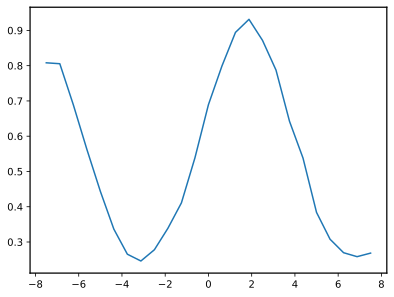

In [21]:
plt.plot(betas, state1_5rep)

## Detuning correction

To suppress *both* leakage and phase errors, we introduce the derivative reduction by adiabatic gate (DRAG) scheme for the pulse envelope, i.e.

\begin{align}
\Omega_{DRAG}(t) = e^{i2\pi\delta f t}(\Omega(t) -i\alpha\dfrac{\dot{\Omega}(t)}{\Delta}
\end{align}

with $\Delta$ being the anharmonicity of the transmon qubit, where $\alpha$ and $\delta f$ are the DRAG weighting and detuning, respectively.

In [23]:
detuning_MHz = np.linspace(-5, 5, 70)
detuning_MHz = detuning_MHz*MHz

In [56]:
qubit_12_freq/GHz

4.409901298950485

In [59]:
detuning_MHz[50]/GHz

0.0022463768115942033

In [24]:
DD12_gate = Gate('Drag Sweep Detuning Gate', weight, [])
number_of_repetition = [1, 5, 10, 15]

DD12_circs = []

for rep in number_of_repetition: 
    
    for detuning in detuning_MHz:
        DD12_circ = QuantumCircuit(num_qubits, num_cbits) # create the circuit
        DD12_circ.x(qubit) # bring the qubit to |1>
            
        # R(theta) concatenates R(-theta) => identity 
        with pulse.build(backend=backend) as drag12s:
            drive_chan = pulse.drive_channel(qubit)
            pulse.set_frequency(qubit_12_freq+detuning, drive_chan)
            pulse.play(pulse.Drag(duration=160, amp=+1*p12_amp, sigma=40, beta=2.0), drive_chan)
            pulse.play(pulse.Drag(duration=160, amp=-1*p12_amp, sigma=40, beta=2.0), drive_chan)
        
        for r in range(rep):
            DD12_circ.append(DD12_gate, [qubit])
            
        DD12_circ.add_calibration(DD12_gate, [qubit], drag12s)
        DD12_circ.measure(qubit, cbit)
        
        DD12_circs.append(DD12_circ)
        
DD12_circs = qiskit.transpile(DD12_circs, backend=backend)

In [29]:
package = discrim_circs + DD12_circs

In [30]:
detuning12_exp = backend.run(package, meas_level=1, meas_return='single', shots=2048)

In [31]:
detuning12_data = DataAnalysis(experiment=detuning12_exp, average=False, shots=2048, qubit=0)
detuning12_data.retrieve_data(average=False)
detuning12_data.build_discrim()
detuning12_data.count_pop()
detuning12_data.error_mitiq()

In [48]:
st0_rep15 = detuning12_data.mitiq_data[213:283, 0]
st1_rep15 = detuning12_data.mitiq_data[213:283, 1]
st2_rep15 = detuning12_data.mitiq_data[213:283, 2]

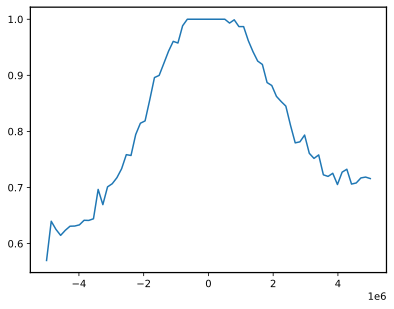

In [51]:
plt.plot(detuning_MHz, st1_rep1)

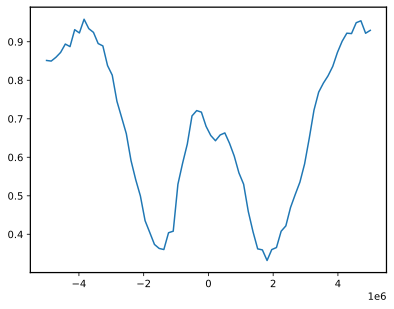

In [52]:
plt.plot(detuning_MHz, st1_rep5)

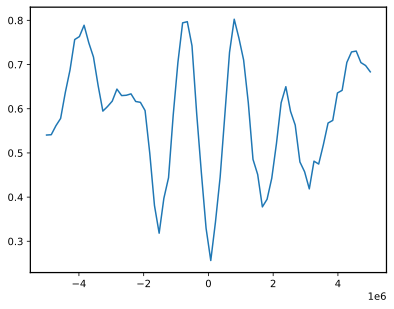

In [53]:
plt.plot(detuning_MHz, st1_rep10)

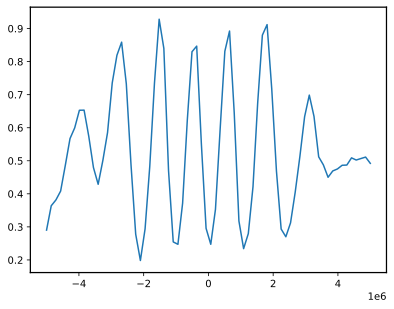

In [54]:
plt.plot(detuning_MHz, st1_rep15)